In [41]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

**Регуляризация** -- это метод борьбы с переобучением, который штрафует модель за излишнюю сложность, что позволяет строить более простые (и потому стабильные) зависимости.

Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**.Eсли оптимальных решений задачи минимизации оказывается бесконечно много, то коэффициенты модели могут принимать какие угодно огромные значения. **Вывод**: необходимо *ограничить величину* коэффициентов модели.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации.

Функция потерь для линейной регрессии с регуляризацией выглядит следующим образом:
$$L(\mathbf{w}) = \frac{1}{\ell}\sum_{i=1}^{\ell}(\langle \mathbf{w} , x^i \rangle - y^i)^2 + R(\tilde{ \mathbf{w}}) \rightarrow \min_{w}$$
где $\tilde {\mathbf{w}} =  (w_1, \ldots, w_n)$ --- вектор весов без свободного члена $w_0$.

Последнее слагаемое определяет вид регуляризации.
* $L_1$-регуляризация (LASSO, least absolute shrinkage and selection operator):
$$R( \mathbf{\tilde w}) = \lambda|| \mathbf{\tilde {w}}||_1 = \lambda (|w_1| + \ldots + |w_n|);$$
* $L_2$-регуляризация (Ridge):
$$R(\tilde{ \mathbf{w}}) = \lambda||\tilde{ \mathbf{w}}||_2^2 = \lambda(|w_1|^2 + \ldots + |w_n|^2);$$
* ElasticNet -- комбинация двух предыдущих:
 $$R(\tilde{ \mathbf{w}}) = \alpha ||\tilde{\mathbf{w}}||_1+ \beta ||\tilde {\mathbf{w}}||_2^2.$$



## Lasso-регрессия

В LASSO-регрессии штрафуем модель **на сумму модулей всех ее весов**.

**Лосс:** $$L(\mathbf{w}) = \frac{1}{\ell} ||X\mathbf{w} - \mathbf{y}||^2_2 + \lambda ||\tilde{\mathbf{w}}||_1,$$ где $\lambda$ -- гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $$L(\mathbf{w}) = \frac{1}{\ell}\sum_{i=1}^{\ell}\left(\sum_{j=0}^{n} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{n}|w_j|$$



**Градиент:**
$$
\frac{\partial{L}}{\partial{\mathbf{w}}}
= \frac{2}{\ell}\cdot X^T(X\mathbf{w} - \mathbf{y}) + \lambda (0, \mathrm{sign}(w_1), \ldots, \mathrm{sign}(w_n))^T.
$$

In [6]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)


class MyLassoRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C

    def regularization_term(self, weights):
        signs = np_soft_sign(weights)
        signs[0] = 0 
        return signs

    def grad(self, X, y, weights):
        y_pred = (X @ weights)

        basic_term = (2. / X.shape[0]) * (X.T @ (y_pred - y))

        regularization_term = self.regularization_term(weights)

        return basic_term + self.C * regularization_term 


    def fit(self, X, y, max_iter=100, lr=0.1):
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]

        l, n = X.shape
        X_train = np.hstack([np.ones([l, 1]), X])

        weights = np.random.randn(n + 1, 1)

        losses = []

        for iter_num in range(max_iter):
            grad = self.grad(X_train, y, weights)
            
            weights -= grad * lr / ((iter_num + 1) ** 0.5)

            loss = np.mean((X_train @ weights - y) ** 2) + self.C * np.sum(np.abs(weights[1:]))
            losses.append(loss)

        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict(self, X):
        X = np.array(X)
        y_pred = X @ self.coef_ + self.intercept_

        return y_pred

In [7]:
def linear_expression(x):
    return 5 * x + 6

In [9]:
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

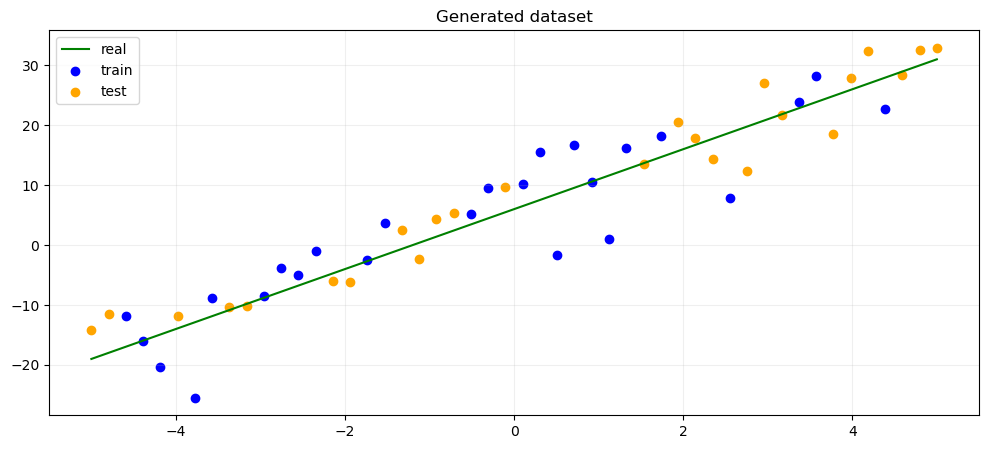

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [11]:
regressor = MyLassoRegression()

losses = regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])

In [12]:
regressor.coef_, regressor.intercept_

(array([[4.74594983]]), array([6.04804952]))

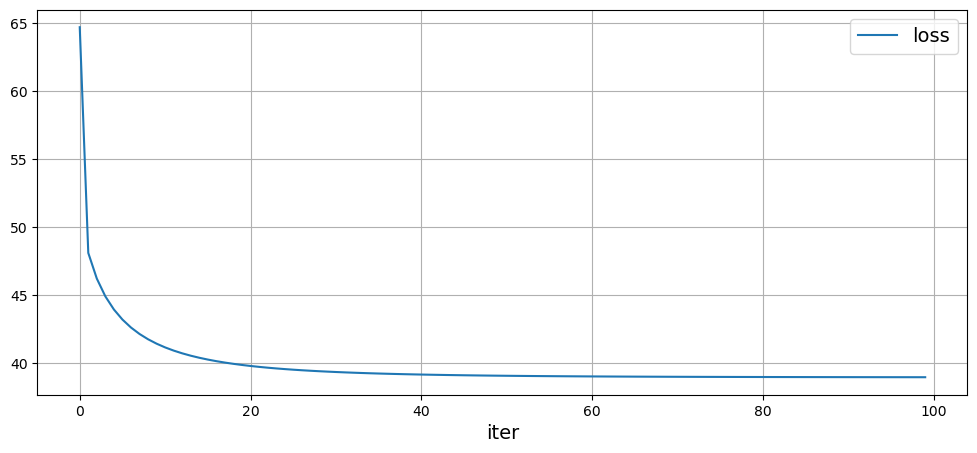

In [14]:
plt.figure(figsize=(12,5))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

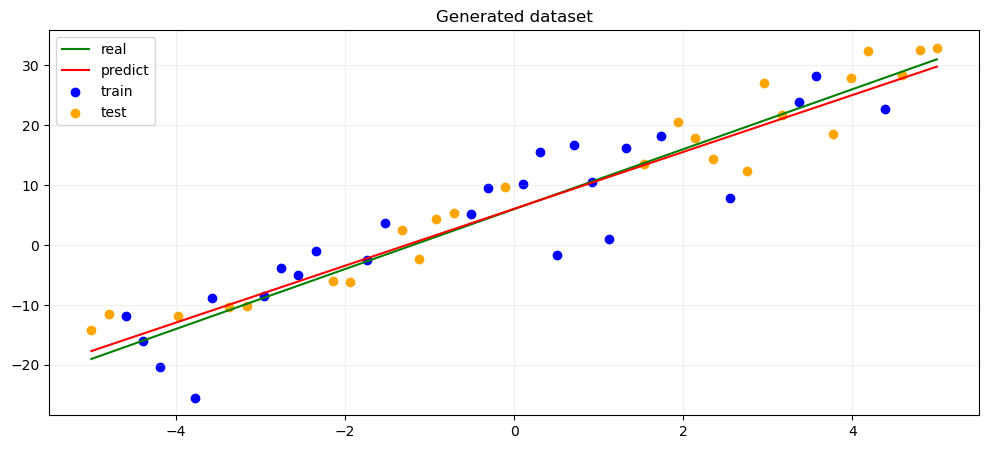

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predict', c='r')

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

### датасет

In [19]:
data = load_diabetes()
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [20]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)


In [23]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
np.mean(X_train_scaled, axis=0)
np.std(X_train_scaled, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
model = MyLassoRegression(C=0.001)
losses = model.fit(X_train_scaled, y_train)

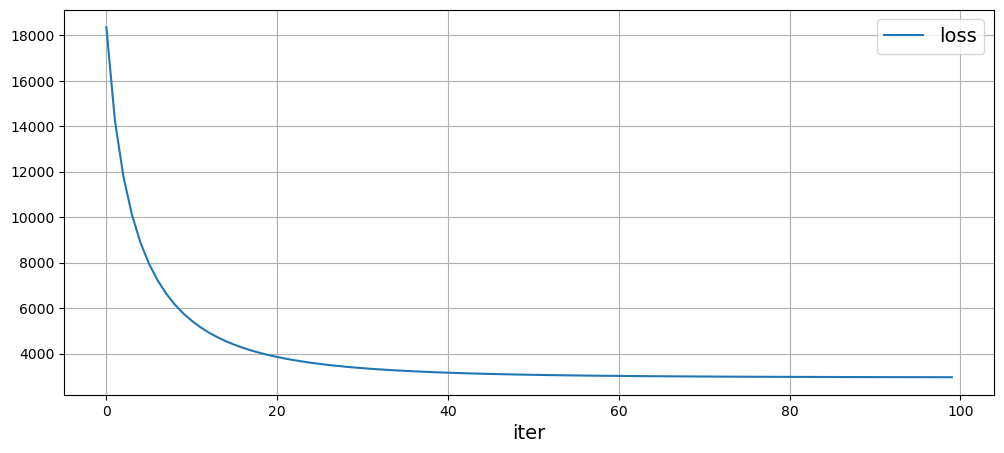

In [27]:
plt.figure(figsize=(12,5))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

<BarContainer object of 10 artists>

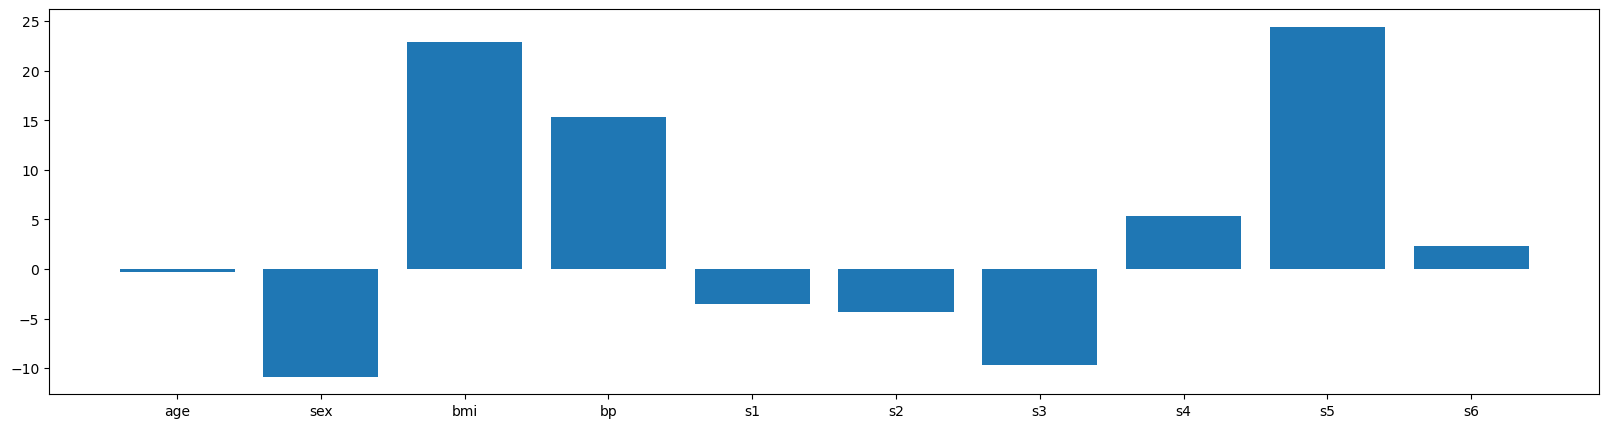

In [29]:
plt.figure(figsize=(20, 5))
plt.bar(X.columns, model.coef_.ravel())

In [31]:
y_train_prediction = model.predict(X_train_scaled)
y_test_prediction = model.predict(X_test_scaled)

print(f'Train MSE: {mean_squared_error(y_train, y_train_prediction)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_prediction)}')

Train MSE: 2956.885333052278
Test MSE: 2825.8882740252884


In [32]:
model.coef_, model.intercept_

(array([[ -0.31895211],
        [-10.87340063],
        [ 22.84980476],
        [ 15.32412149],
        [ -3.4915215 ],
        [ -4.32898236],
        [ -9.65953198],
        [  5.33625459],
        [ 24.43477174],
        [  2.31601582]]),
 array([146.83709649]))

### Величина весов в зависимости от коэффициента регуляризации

In [33]:
reg_coefs = np.linspace(10, 100, 50)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = MyLassoRegression(C=C)
    lasso_regressor.fit(X_train_scaled, y_train, lr=0.05, max_iter=5000)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

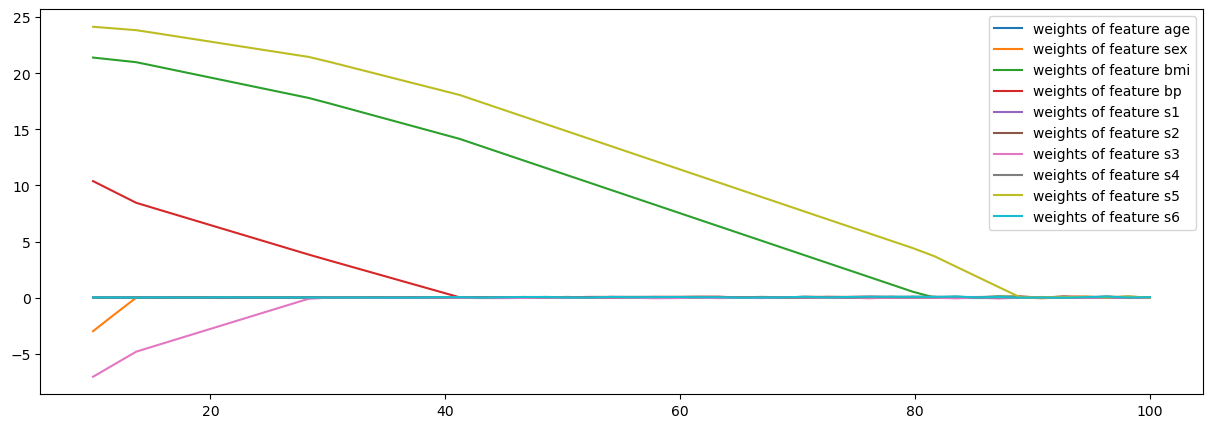

In [34]:
plt.figure(figsize=(15,5))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

In [38]:
reg_coefs = np.linspace(5, 50, 50)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = Lasso(alpha=C)
    lasso_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

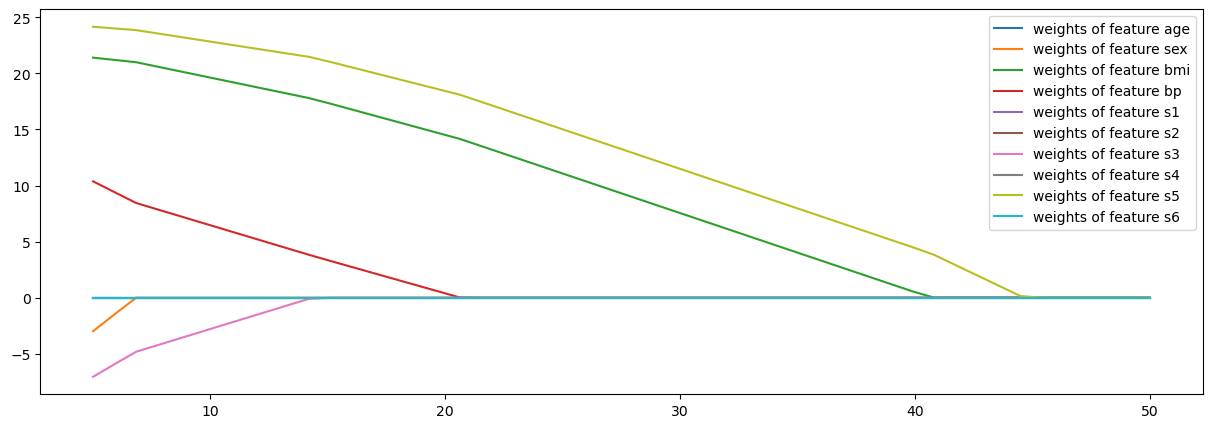

In [40]:
plt.figure(figsize=(15,5))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

## Ridge регрессия (L2-регуляризация)

В ridge штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:**
$$L(\mathbf{w}) = ||X\mathbf{w} - \mathbf{y}||^2_2 + \lambda||\mathbf{\tilde{w}}||^2_2 = \sum_{i=1}^{\ell}\left(\sum_{j=0}^{n} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{n}w_j^2,$$
где $\lambda$ --- гиперпараметр, отвечающий за степень регуляризации.

Значения признаков должны быть стандартизованы для одинаковых штрафов относительно друг друга

In [43]:
reg_coefs = np.linspace(1, 10000, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    ridge_regressor = Ridge(C)
    ridge_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))

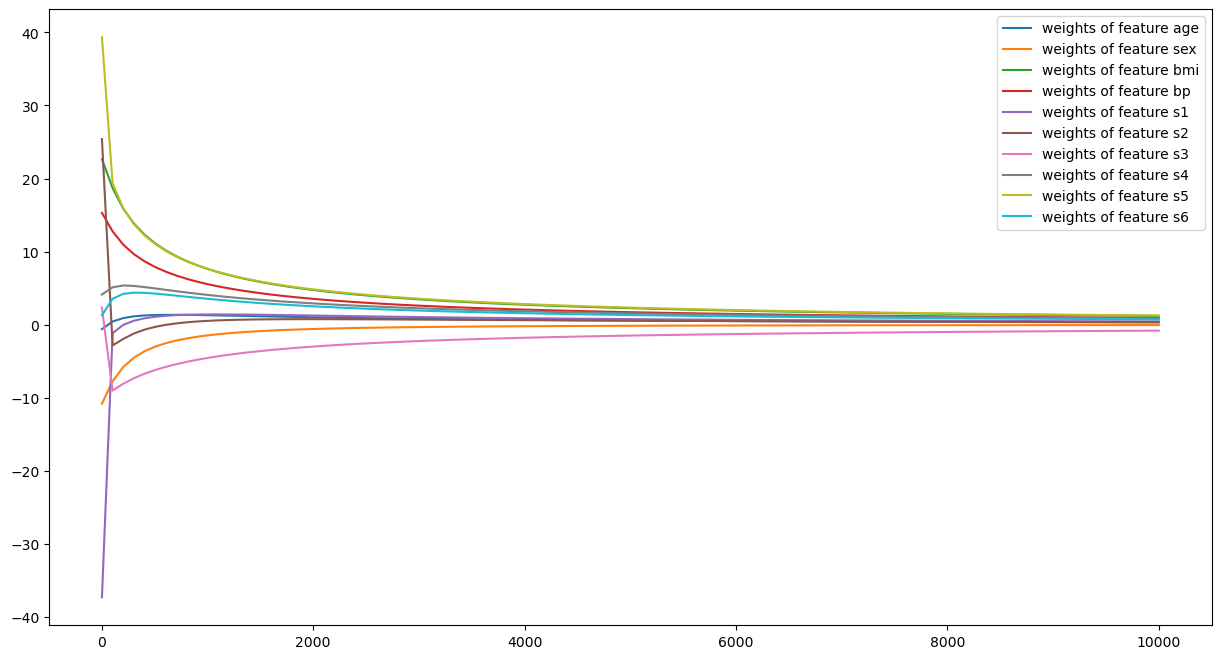

In [46]:
plt.figure(figsize=(15,8))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()